# Attention tokens

Attention heads appear to learn distinct sets of "attention tokens", which act as a compacted vocabulary set used to describe the input within that head. I define dttention tokens as the element-wise (Hadamard) product of each query against each key in the input up to and including the query's position. This is then projected onto the residual stream using the head's OV matrix and unembeded to decode a specific token. This token is the attention token.

Using this approach, different heads learn different attention token sets, but there are some common tokens shared between all heads (e.g. " the" "<NEWLINE>", " and"). Further, heads consistently convert inputs that are structurally or semantically similar, but use different language, to similar patterns of attention tokens. The patterns that heads use to represent inputs varies - some massively contract the input sequence into chunks while others appear linear or expand the input. Intuitevely, this tracks with some known behaviours - e.g. 10.7, known to supress copying, expands input, which might be necessary for it's task given the focus on tokens and not structure.

At the very least, this feels like a compelling way to categorise attention heads based on how they tend to restructure given inputs. But, I hope that it may also point to a direction for understanding attention mechanisms in a more rigourous way - see the final section for some highly speculative on how some ideas from group theory and physics could be used to help further this goal.

In [1]:
import torch
from transformer_lens import HookedTransformer, SVDInterpreter
import plotly.io as pio
pio.renderers.default = "png"

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


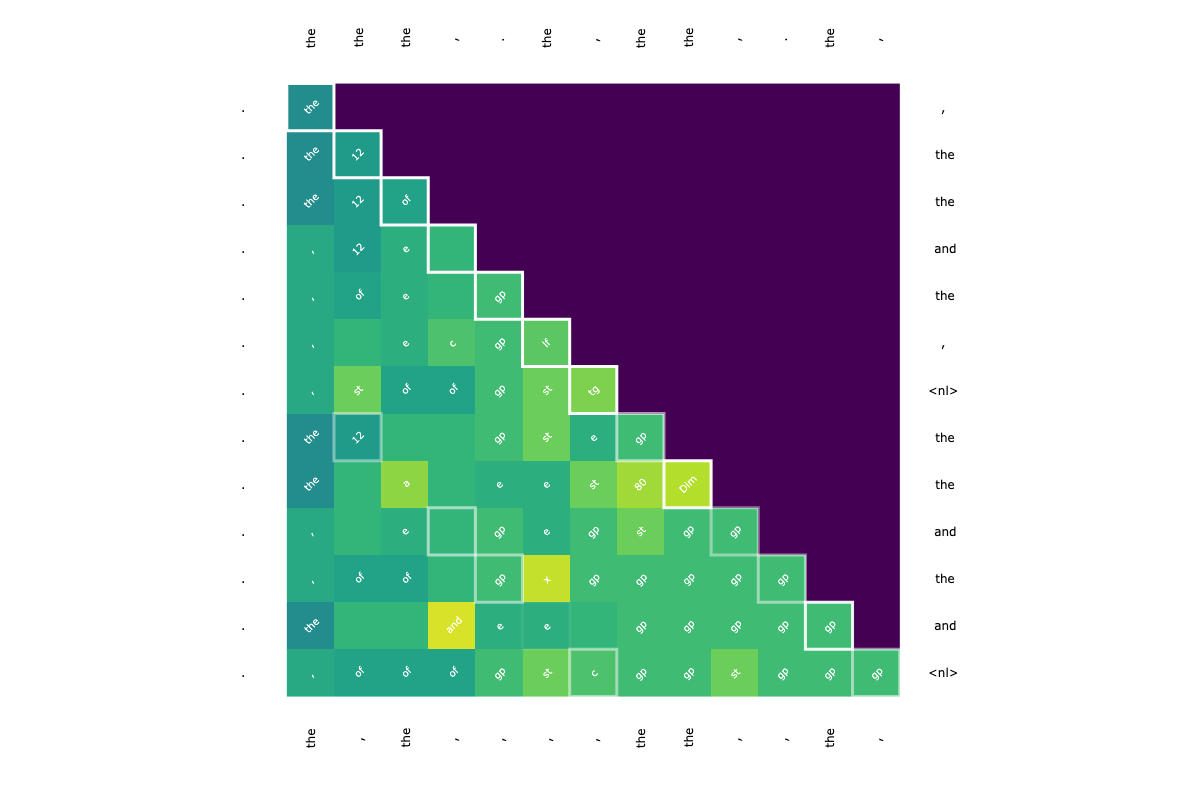

In [2]:
cache = run_prompts(model, "The next sentence is false. The previous sentence is true.")
plot_attn(cache, 0, 1)

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")
len(dataset["train"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


25000

In [4]:
inputs = random.choices(dataset["train"]["text"], k=4)

plots = []
l1, h1 = 0, 10
for i, text in enumerate(inputs):
    prompt = ' '.join(text.split(' ')[:16])
    cache = run_prompts(model, prompt)
    plots.append(plot_attn(cache, l1, h1, hide_labels=True, title=f'{chr(i + 65)} / {l1}.{h1}'))

l2, h2 = 0, 11
for i, text in enumerate(inputs):
    prompt = ' '.join(text.split(' ')[:16])
    cache = run_prompts(model, prompt)
    plots.append(plot_attn(cache, l2, h2, hide_labels=True, title=f'{chr(i + 65)} / {l2}.{h2}'))

plot_grid(*plots, title=f"Comparing random IMDB review inputs across {l1}.{h1} and {l2}.{h2}",
    description=f"""
    While specific patterns are hard to pin down, common motifs across the reviews are clearly visible. 0.10 creates patterns that flip the input into mostly similar attention tokens. 0.11 does the opposite, creating patterns that are mostly stable across local input changes.
    """,
    footer='<br>'.join([f'{chr(i + 65)}: "<i>{text[:99]}...</i>"' for i, text in enumerate(inputs)]),
)

In [172]:
inputs = random.choices(dataset["train"]["text"], k=4)
inputs = model.to_string(model.to_tokens(inputs)[:, :32])
cache = run_prompts(model, *inputs)

In [24]:
data = torch.stack([
    calculate_attns(cache, *head_index(i))
    for i in range(144)
])

data.shape

torch.Size([144, 16, 17, 17, 6])

In [173]:
data_32 = torch.stack([
    calculate_attns(cache, *head_index(i))
    for i in range(144)
])

data_32.shape

torch.Size([144, 4, 33, 33, 6])

In [186]:
r = []
for _ in range(3):
    inputs = random.choices(dataset["train"]["text"], k=4)
    inputs = model.to_string(model.to_tokens(inputs)[:, :32])
    cache = run_prompts(model, *inputs)
    r += [calculate_attns(cache, *head_index(i)) for i in range(144)]

new_data = torch.stack(r)

KeyboardInterrupt: 

In [ ]:
data_32_new = torch.cat([data_32, new_data])
data_32_new.shape

In [ ]:
s = []
for _ in range(8):
    inputs = random.choices(dataset["train"]["text"], k=16)
    inputs = model.to_string(model.to_tokens(inputs)[:, :16])
    cache = run_prompts(model, *inputs)
    s += [calculate_attns(cache, *head_index(i)) for i in range(144)]

new_16_data = torch.stack(s)
new_16_data.shape n

In [23]:
import torch
import pandas as pd

# Assuming you have a tensor named 'data' with shape (8, 17, 17, 6)
data_np = data_32_new.cpu().numpy()

# Reshape the numpy array to flatten the first three dimensions
reshaped_data = data_np.reshape(-1, 6)

# Create a pandas DataFrame from the reshaped numpy array
df = pd.DataFrame(reshaped_data)
df

Token  Frequency
0      the        851
1        ,        660
2       in        654
3      orn        146
4      and         94
5   rontal         17
6       NI         10
7       \n          7
8      NFC          7
9    stick          1
10    Gunn          1

In [ ]:
df.to_csv('32x32_attn.csv', index=False)

In [ ]:
# Select the second feature column (index 2)
second_feature = df.iloc[:, 2]
second_feature = second_feature[second_feature != -1]

# Get the unique tokens and their frequencies
token_counts = second_feature.value_counts()

# Decode the token integers to strings using cache.model.to_single_str_token()
decoded_tokens = [cache.model.to_single_str_token(int(i)) for i in token_counts.index]

# Create a new DataFrame with decoded tokens and their frequencies
result_df = pd.DataFrame({'Token': decoded_tokens, 'Frequency': token_counts.values})

# Print the resulting DataFrame
print(result_df)

In [105]:
import torch
import pandas as pd

# Assuming you have a tensor named 'data' with shape (head, batch, seq_len, seq_len, features)
# e.g., (144, 16, 17, 17, 64) for gpt2-small

# Select the desired feature index
feature_index = 2

# Select the desired feature from the data tensor
feature_data = data[:, :, :, :, feature_index]

# Flatten the tensor along the head, batch, seq_len, and seq_len dimensions
flattened_data = feature_data.view(-1)

# Convert the flattened data to a numpy array
flattened_data_np = flattened_data.cpu().numpy()

# Create a DataFrame with the flattened data
df = pd.DataFrame({'Token': flattened_data_np})

# Filter out null values (-1) from the DataFrame
df = df[df['Token'] != -1]

# Add a 'Head' column to the DataFrame
df['Head'] = df.index // (data.shape[1] * data.shape[2] * data.shape[3])

# Calculate the token frequencies grouped by head
token_counts = df.groupby(['Head', 'Token']).size().reset_index(name='Frequency')

# Convert the 'Token' column to integers
token_counts['Token'] = token_counts['Token'].astype(int)

# Decode the token integers to strings using cache.model.to_single_str_token()
token_counts['Token str'] = token_counts['Token'].apply(cache.model.to_single_str_token)

# Print the resulting DataFrame
token_counts

,Head,Token,Frequency,Token str
0,0,11,660,","
1,0,198,7,\n
2,0,262,851,the
3,0,287,654,in
4,0,290,94,and
...,...,...,...,...
16502,143,49268,2,Carth
16503,143,49309,55,raised
16504,143,49507,9,curls
16505,143,50026,2,Ulster


In [112]:
# Assuming you have a tensor named 'data' with shape (head, batch, seq_len, seq_len, features)
# e.g., (144, 16, 17, 17, 64) for gpt2-small

# Select the desired feature index
feature_index = 2

# Select the desired feature from the data tensor
feature_data = data[:, :, :, :, feature_index]

# Flatten the tensor along the head, batch, seq_len, and seq_len dimensions
flattened_data = feature_data.view(-1)

# Convert the flattened data to a numpy array
flattened_data_np = flattened_data.cpu().numpy()

# Create a DataFrame with the flattened data
df = pd.DataFrame({'Token': flattened_data_np})

# Filter out null values (-1) from the DataFrame
df = df[df['Token'] != -1]

# Add a 'Head' column to the DataFrame
df['Head'] = df.index // (data.shape[1] * data.shape[2] * data.shape[3])

# Calculate the token frequencies grouped by head
token_counts = df.groupby(['Head', 'Token']).size().reset_index(name='Frequency')

# Convert the 'Token' column to integers
token_counts['Token'] = token_counts['Token'].astype(int)

# Decode the token integers to strings using cache.model.to_single_str_token()
token_counts['Token str'] = token_counts['Token'].apply(cache.model.to_single_str_token)

# Count the number of unique heads for each token
token_head_counts = token_counts.groupby('Token')['Head'].nunique().reset_index(name='Head_Count')

# Specify the minimum number of heads a token should be shared across
min_shared_heads = 2

# Filter the tokens that are shared across at least min_shared_heads
shared_tokens = token_head_counts[token_head_counts['Head_Count'] >= min_shared_heads]

# Print the shared tokens and their head counts
shared_tokens.sort_values(by='Head_Count', ascending=False)

,Token,Head_Count
120,262,85
9,11,78
139,290,54
93,198,43
136,284,28
...,...,...
1398,3172,2
5412,20701,2
5408,20659,2
1402,3180,2


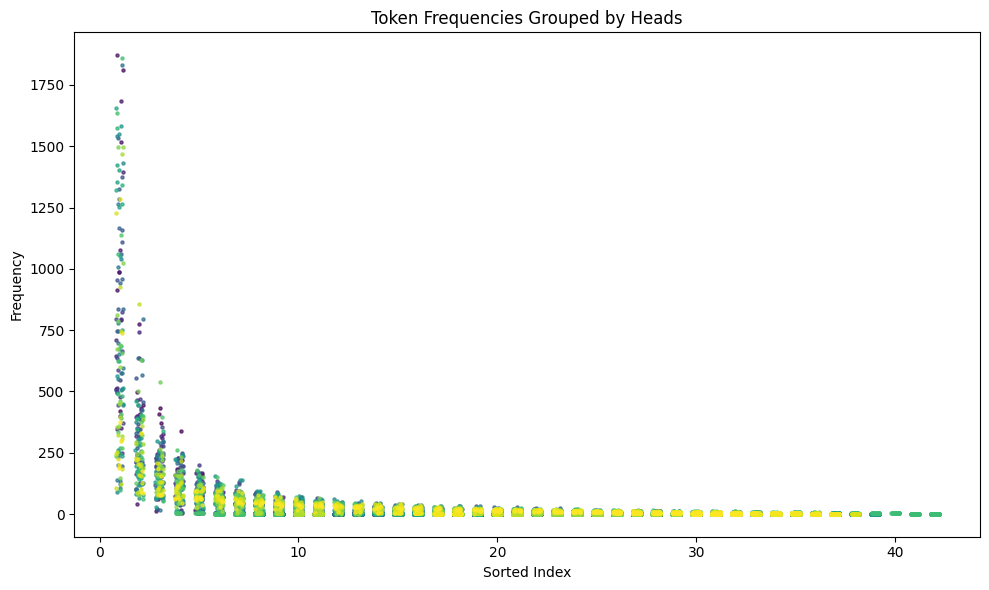

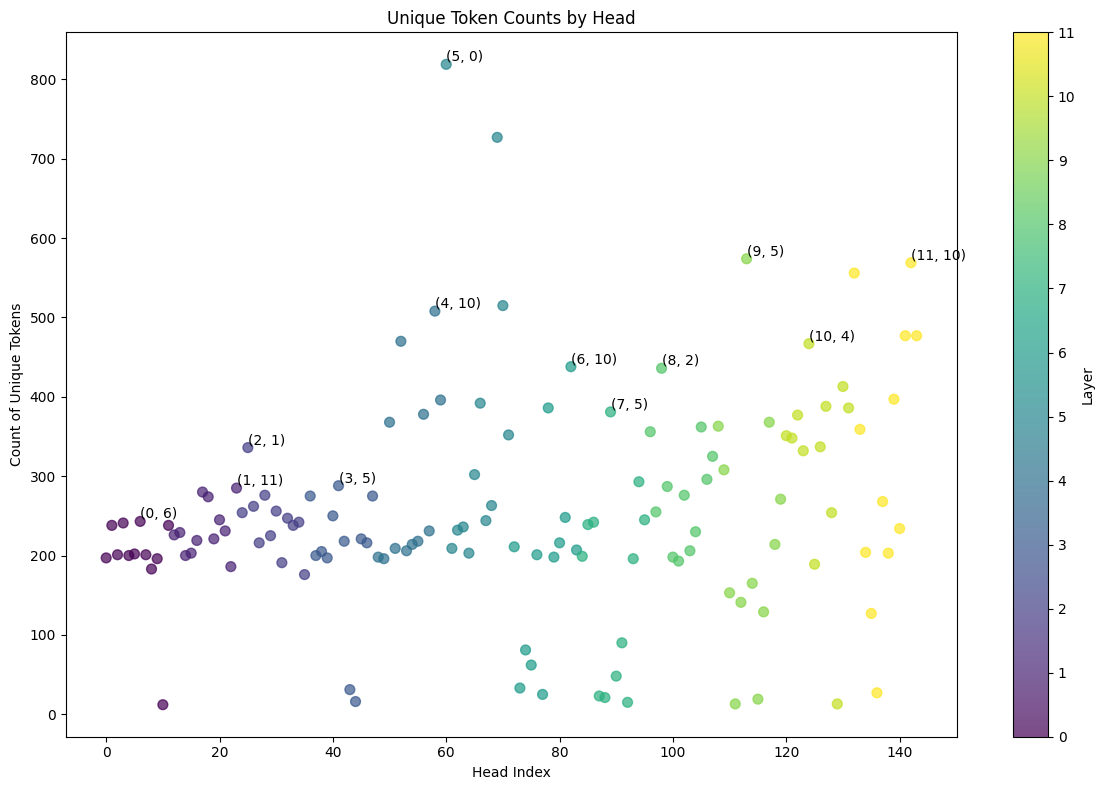

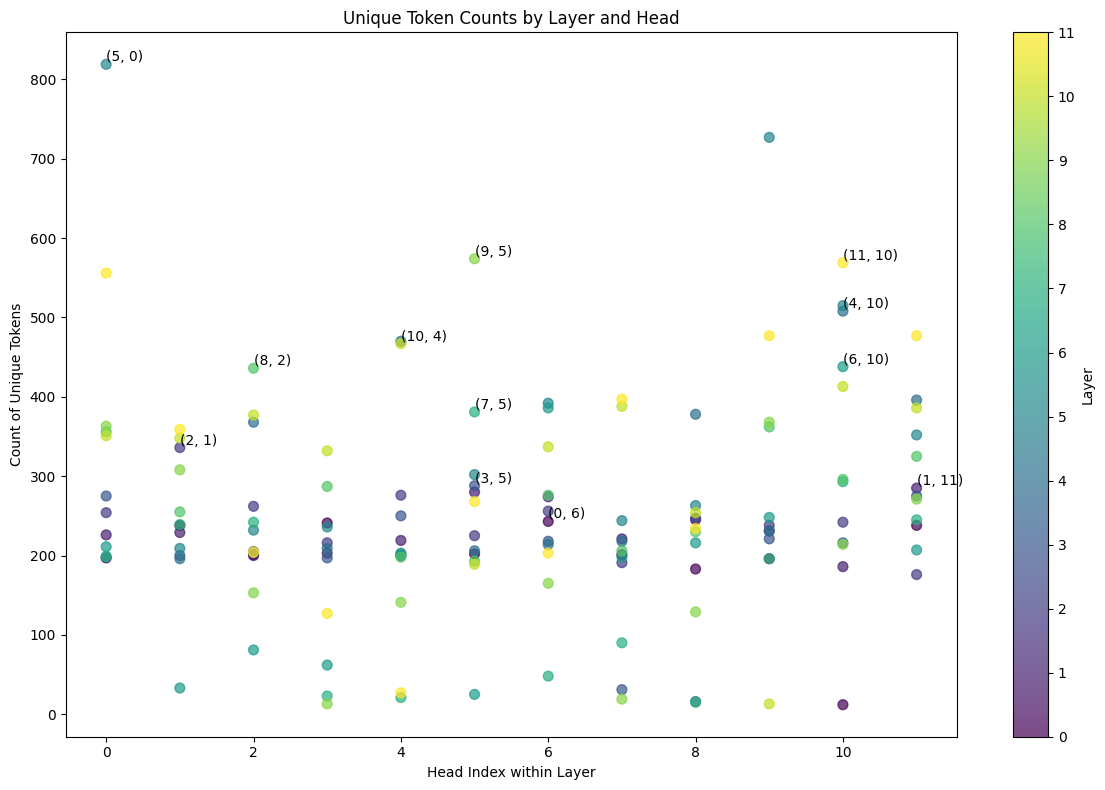

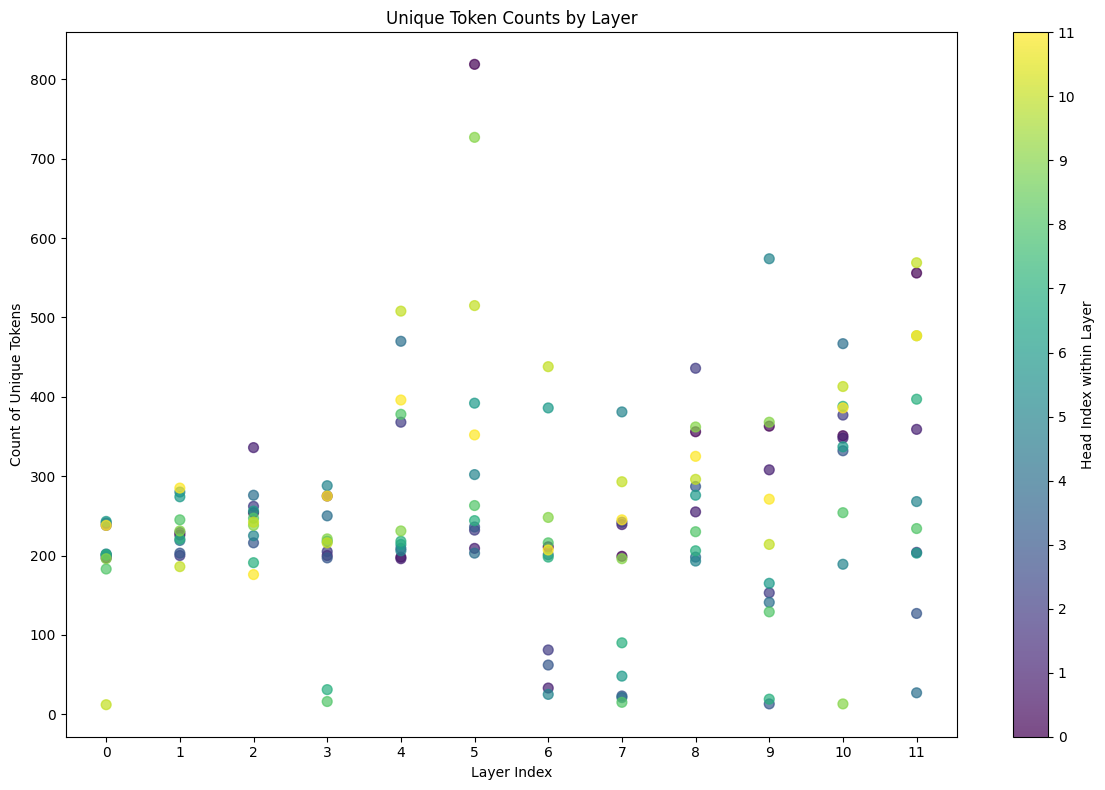

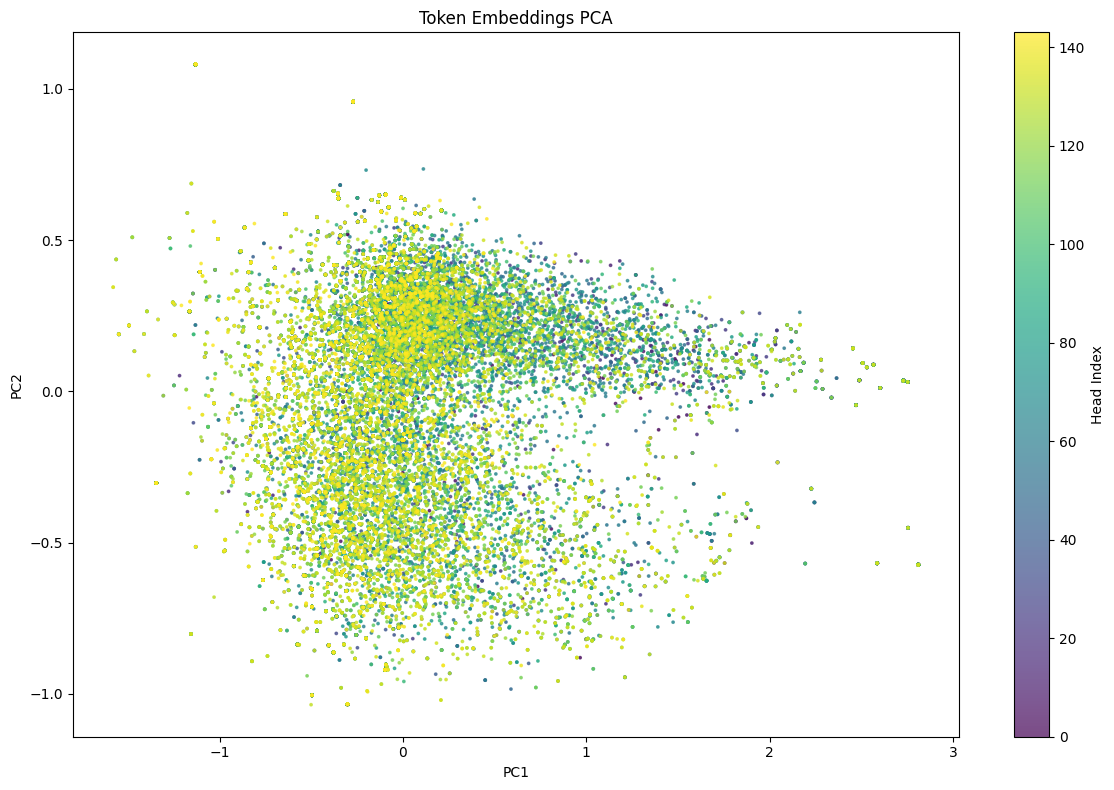

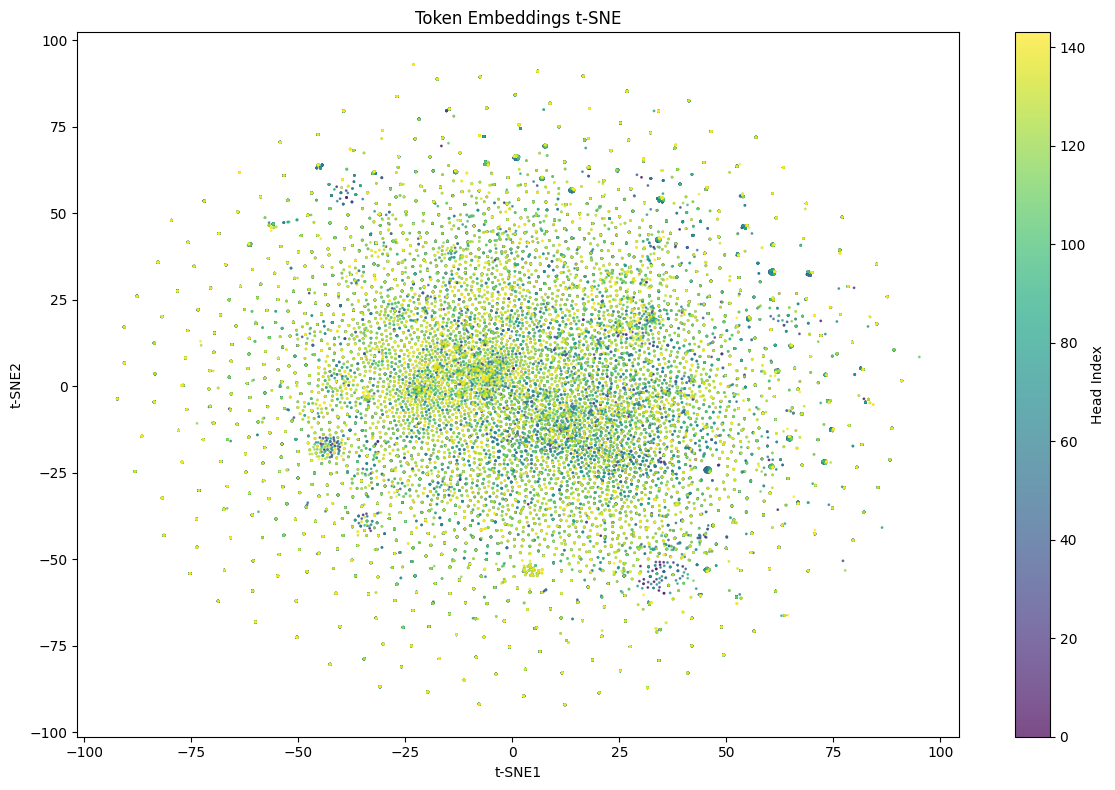

In [185]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def select_feature(data, feature_index):
    return data[:, :, :, :, feature_index]

def flatten_tensor(feature_data):
    return feature_data.view(-1)

def convert_to_numpy(flattened_data):
    return flattened_data.cpu().numpy()

def create_dataframe(flattened_data_np):
    return pd.DataFrame({'Token': flattened_data_np})

def filter_null_values(df):
    return df[df['Token'] != -1]

def add_head_column(df, data_shape):
    df['Head'] = df.index // (data_shape[1] * data_shape[2] * data_shape[3])
    return df

def calculate_token_frequencies(df):
    return df.groupby(['Head', 'Token']).size().reset_index(name='Frequency')

def decode_tokens(token_counts):
    token_counts['Token'] = token_counts['Token'].astype(int)
    token_counts['Token str'] = token_counts['Token'].apply(cache.model.to_single_str_token)
    return token_counts

def add_sorted_index(token_counts):
    token_counts['SortedIndex'] = token_counts.groupby('Head')['Frequency'].rank(method='dense', ascending=False)
    return token_counts

def plot_token_frequencies(token_counts, num_heads):
    plt.figure(figsize=(10, 6))
    
    # Create a colormap
    colormap = cm.viridis(np.linspace(0, 1, num_heads))
    
    for i in range(num_heads):
        head_data = token_counts[token_counts['Head'] == i]
        
        # Generate jitter values specific to each head
        jitter = np.random.uniform(-0.2, 0.2, size=len(head_data))
        
        plt.scatter(head_data['SortedIndex'] + jitter, head_data['Frequency'], color=colormap[i], s=5, alpha=0.7)

    plt.xlabel('Sorted Index')
    plt.ylabel('Frequency')
    plt.title('Token Frequencies Grouped by Heads')
    
    plt.tight_layout()
    plt.show()

def main(data, feature_index):
    feature_data = select_feature(data, feature_index)
    flattened_data = flatten_tensor(feature_data)
    flattened_data_np = convert_to_numpy(flattened_data)
    df = create_dataframe(flattened_data_np)
    df = filter_null_values(df)
    df = add_head_column(df, data.shape)
    token_counts = calculate_token_frequencies(df)
    token_counts = decode_tokens(token_counts)
    token_counts = add_sorted_index(token_counts)
    plot_token_frequencies(token_counts, data.shape[0])
    plot_unique_tokens_by_head(token_counts, 12, 12)
    plot_unique_tokens_by_layer_head(token_counts, 12, 12)
    plot_unique_tokens_by_layer(token_counts, 12, 12) 
    plot_token_embeddings_pca(token_counts, num_components=2, jitter_scale=0)
    plot_token_embeddings_umap(token_counts, n_neighbors=25, min_dist=0.5, jitter_scale=0.001)
    plot_token_embeddings_tsne(token_counts, perplexity=30, learning_rate=200)

# Assuming you have a tensor named 'data' with shape (head, batch, seq_len, seq_len, features)
# e.g., (144, 16, 17, 17, 64) for gpt2-small
feature_index = 2
main(data_32, feature_index)

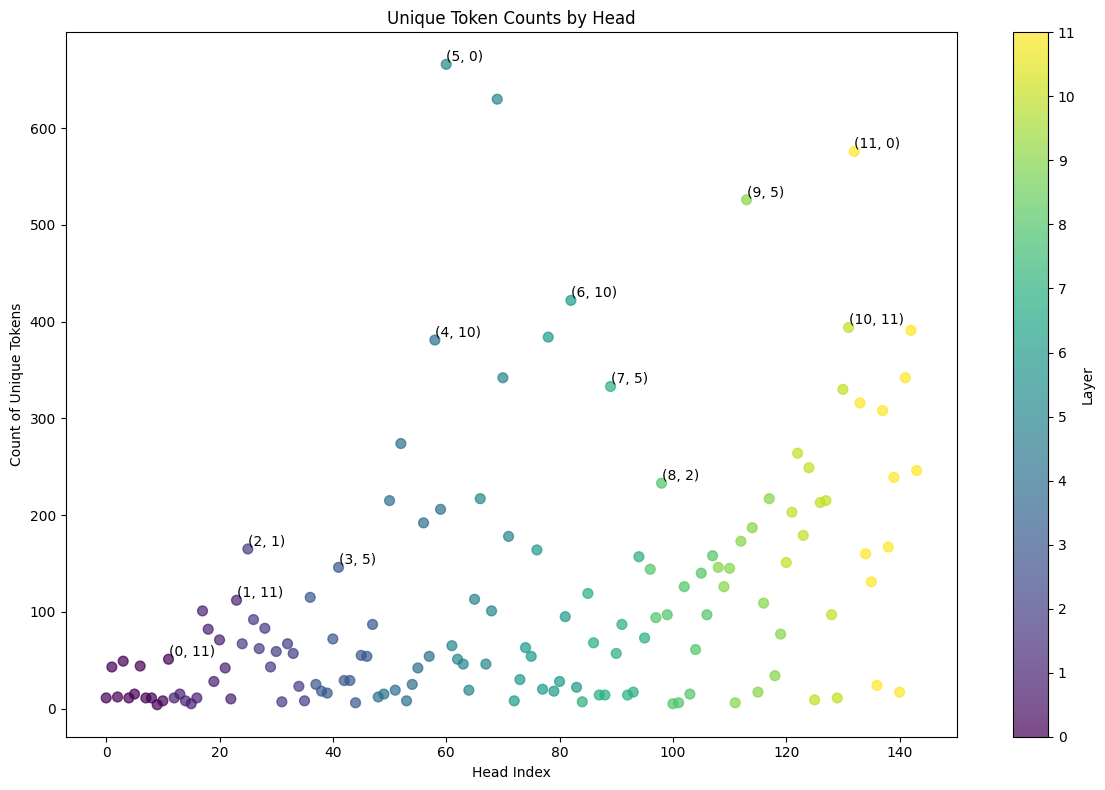

In [175]:
def plot_unique_tokens_by_head(token_counts, num_layers, num_heads_per_layer, show_max_labels=True):
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colormap = cm.viridis
    
    # Calculate the count of unique tokens for each head
    unique_token_counts = token_counts.groupby('Head')['Token'].nunique().reset_index(name='Unique Tokens')
    
    # Add a layer column based on the head index
    unique_token_counts['Layer'] = unique_token_counts['Head'] // num_heads_per_layer
    
    # Create a scatter plot
    plt.scatter(unique_token_counts['Head'], unique_token_counts['Unique Tokens'],
                c=unique_token_counts['Layer'], cmap=colormap, s=50, alpha=0.7)
    
    if show_max_labels:
        # Find the maximum value for each layer
        max_values = unique_token_counts.groupby('Layer')['Unique Tokens'].max()

        # Add labels for the maximum value in each layer
        for layer, max_value in max_values.items():
            max_index = unique_token_counts[
                (unique_token_counts['Layer'] == layer) & 
                (unique_token_counts['Unique Tokens'] == max_value)
            ].index[0]
            max_head = unique_token_counts.loc[max_index, 'Head']
            layer_index, head_pos = head_index(max_head)
            plt.text(max_head, max_value, f'({layer_index}, {head_pos})', fontsize=10, ha='left', va='bottom')
    
    plt.xlabel('Head Index')
    plt.ylabel('Count of Unique Tokens')
    plt.title('Unique Token Counts by Head')
    plt.colorbar(ticks=range(num_layers), label='Layer')
    
    plt.tight_layout()
    plt.show()


plot_unique_tokens_by_head(token_counts, num_layers, num_heads_per_layer)

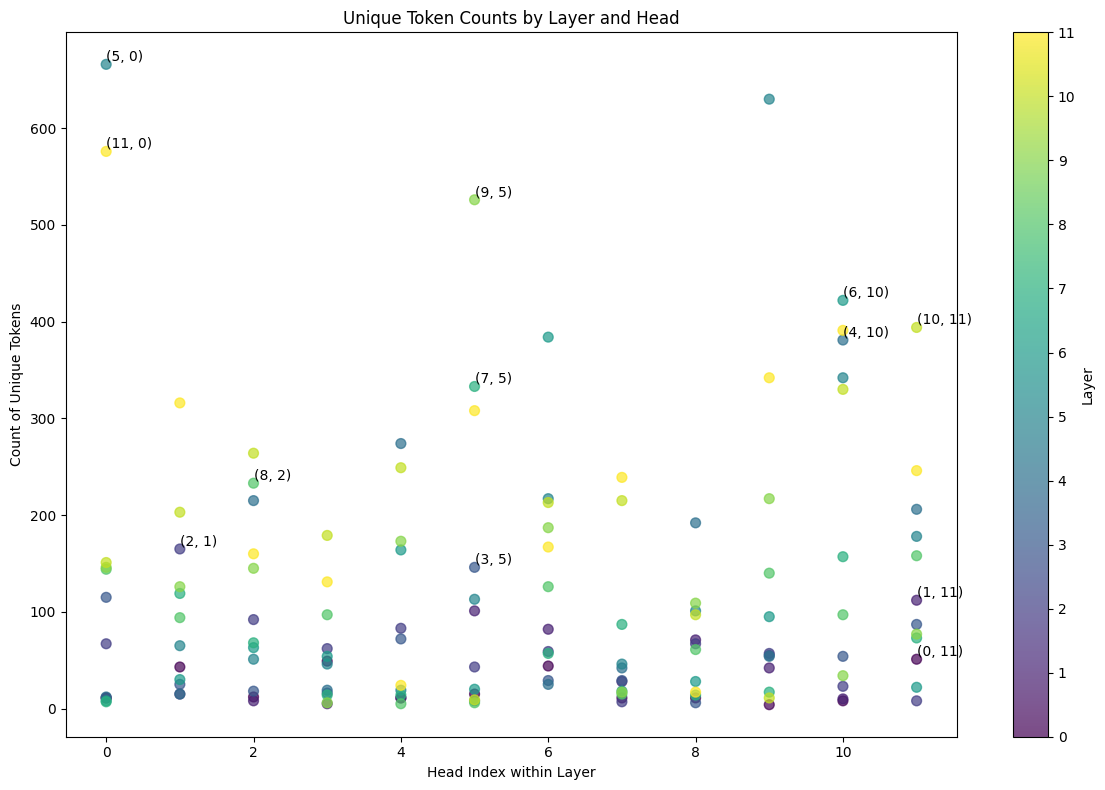

In [176]:
def plot_unique_tokens_by_layer_head(token_counts, num_layers, num_heads_per_layer, show_max_labels=True):
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colormap = cm.viridis
    
    # Calculate the count of unique tokens for each head
    unique_token_counts = token_counts.groupby('Head')['Token'].nunique().reset_index(name='Unique Tokens')
    
    # Add a layer column and head index within layer column
    unique_token_counts['Layer'] = unique_token_counts['Head'] // num_heads_per_layer
    unique_token_counts['Head Index within Layer'] = unique_token_counts['Head'] % num_heads_per_layer
    
    # Create a scatter plot
    plt.scatter(unique_token_counts['Head Index within Layer'], unique_token_counts['Unique Tokens'],
                c=unique_token_counts['Layer'], cmap=colormap, s=50, alpha=0.7)
    
    if show_max_labels:
        # Find the maximum value for each layer
        max_values = unique_token_counts.groupby('Layer')['Unique Tokens'].max()
        
        # Add labels for the maximum value in each layer
        for layer, max_value in max_values.items():
            max_index = unique_token_counts[
                (unique_token_counts['Layer'] == layer) & 
                (unique_token_counts['Unique Tokens'] == max_value)
            ].index[0]
            max_head_index_within_layer = unique_token_counts.loc[max_index, 'Head Index within Layer']
            plt.text(max_head_index_within_layer, max_value, f'({int(layer)}, {int(max_head_index_within_layer)})',
                     fontsize=10, ha='left', va='bottom')
    
    plt.xlabel('Head Index within Layer')
    plt.ylabel('Count of Unique Tokens')
    plt.title('Unique Token Counts by Layer and Head')
    plt.colorbar(ticks=range(num_layers), label='Layer')
    
    plt.tight_layout()
    plt.show()

plot_unique_tokens_by_layer_head(token_counts, num_layers, num_heads_per_layer)

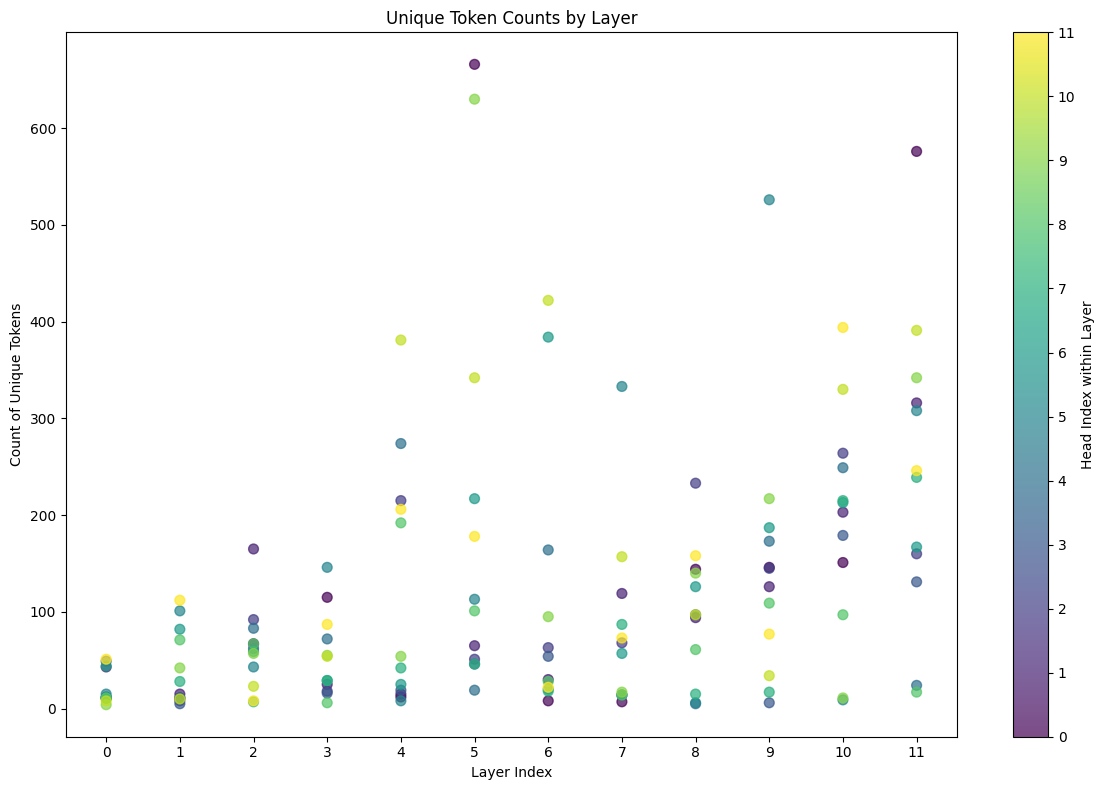

In [177]:
def plot_unique_tokens_by_layer(token_counts, num_layers, num_heads_per_layer, show_max_labels=False):
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colormap = cm.viridis
    
    # Calculate the count of unique tokens for each head
    unique_token_counts = token_counts.groupby('Head')['Token'].nunique().reset_index(name='Unique Tokens')
    
    # Add a layer column and head index within layer column
    unique_token_counts['Layer'] = unique_token_counts['Head'] // num_heads_per_layer
    unique_token_counts['Head Index within Layer'] = unique_token_counts['Head'] % num_heads_per_layer
    
    # Create a scatter plot
    for layer in range(num_layers):
        layer_data = unique_token_counts[unique_token_counts['Layer'] == layer]
        plt.scatter(layer_data['Layer'], layer_data['Unique Tokens'],
                    c=layer_data['Head Index within Layer'], cmap=colormap, s=50, alpha=0.7)
    
    if show_max_labels:
        # Find the maximum value for each layer
        max_values = unique_token_counts.groupby('Layer')['Unique Tokens'].max()
        
        # Add labels for the maximum value in each layer
        for layer, max_value in max_values.items():
            max_index = unique_token_counts[
                (unique_token_counts['Layer'] == layer) & 
                (unique_token_counts['Unique Tokens'] == max_value)
            ].index[0]
            max_head_index_within_layer = unique_token_counts.loc[max_index, 'Head Index within Layer']
            plt.text(layer, max_value, f'({int(max_head_index_within_layer)})',
                     fontsize=10, ha='center', va='bottom')
    
    plt.xlabel('Layer Index')
    plt.ylabel('Count of Unique Tokens')
    plt.title('Unique Token Counts by Layer')
    plt.xticks(range(num_layers))
    plt.colorbar(ticks=range(num_heads_per_layer), label='Head Index within Layer')
    
    plt.tight_layout()
    plt.show()

plot_unique_tokens_by_layer(token_counts, num_layers, num_heads_per_layer)

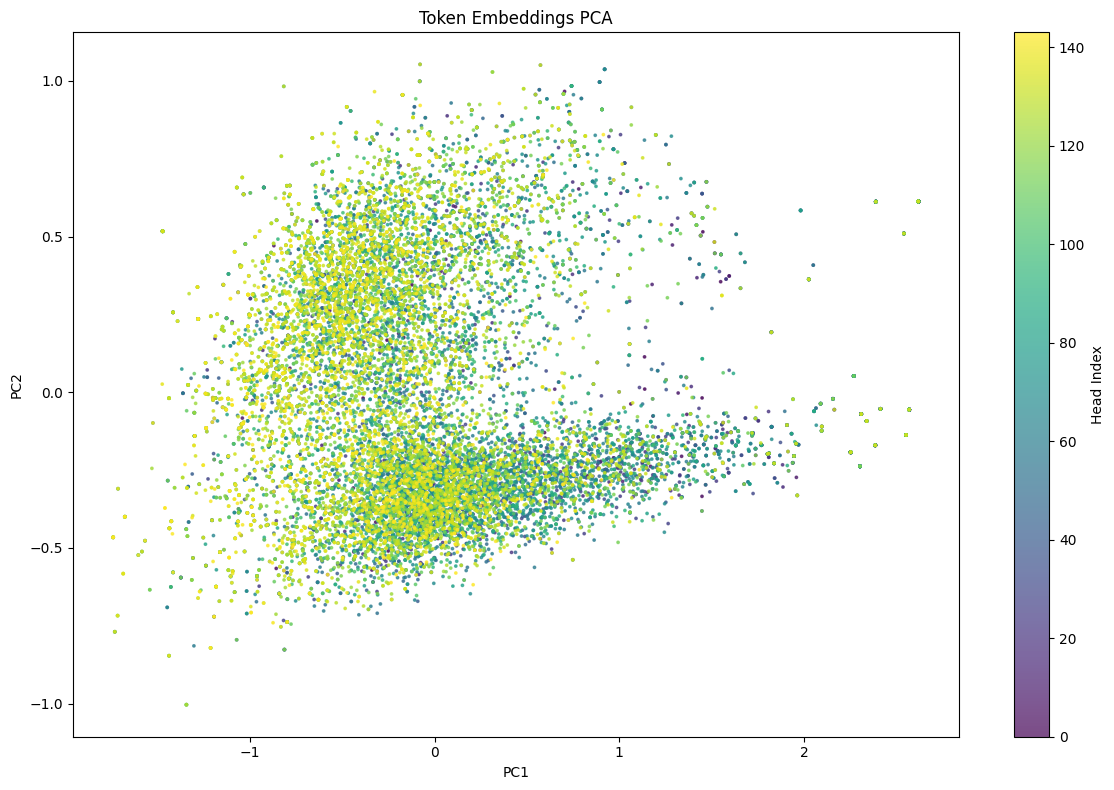

In [163]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA

def plot_token_embeddings_pca(token_counts, num_components=2, jitter_scale=0.0001, c_label='Head'):
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colormap = cm.viridis
    
    # Get the unique tokens and their corresponding heads
    token_heads = token_counts[['Token', c_label]].drop_duplicates()
    
    # Get the token embeddings
    token_embeddings = []
    for token in token_heads['Token']:
        embedding = cache.model.embed(token).detach().cpu().numpy()
        token_embeddings.append(embedding)
    
    # Perform PCA on the token embeddings
    pca = PCA(n_components=num_components)
    token_embeddings_pca = pca.fit_transform(token_embeddings)
    
    # Create a DataFrame with the PCA components and head indices
    df_pca = pd.DataFrame(token_embeddings_pca, columns=[f'PC{i+1}' for i in range(num_components)])
    df_pca['Token'] = token_heads['Token']
    df_pca[c_label] = token_heads[c_label]
    
    # Add jitter to the PCA components
    jitter = np.random.normal(scale=jitter_scale, size=(df_pca.shape[0], 2))
    df_pca[df_pca.columns[:num_components]] += jitter
    
    # Plot the PCA components with color representing the head index
    plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[c_label], cmap=colormap, s=3, alpha=0.7)
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Token Embeddings PCA')
    plt.colorbar(label='Head Index')
    
    plt.tight_layout()
    plt.show()

plot_token_embeddings_pca(token_counts, num_components=2, jitter_scale=0.000)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



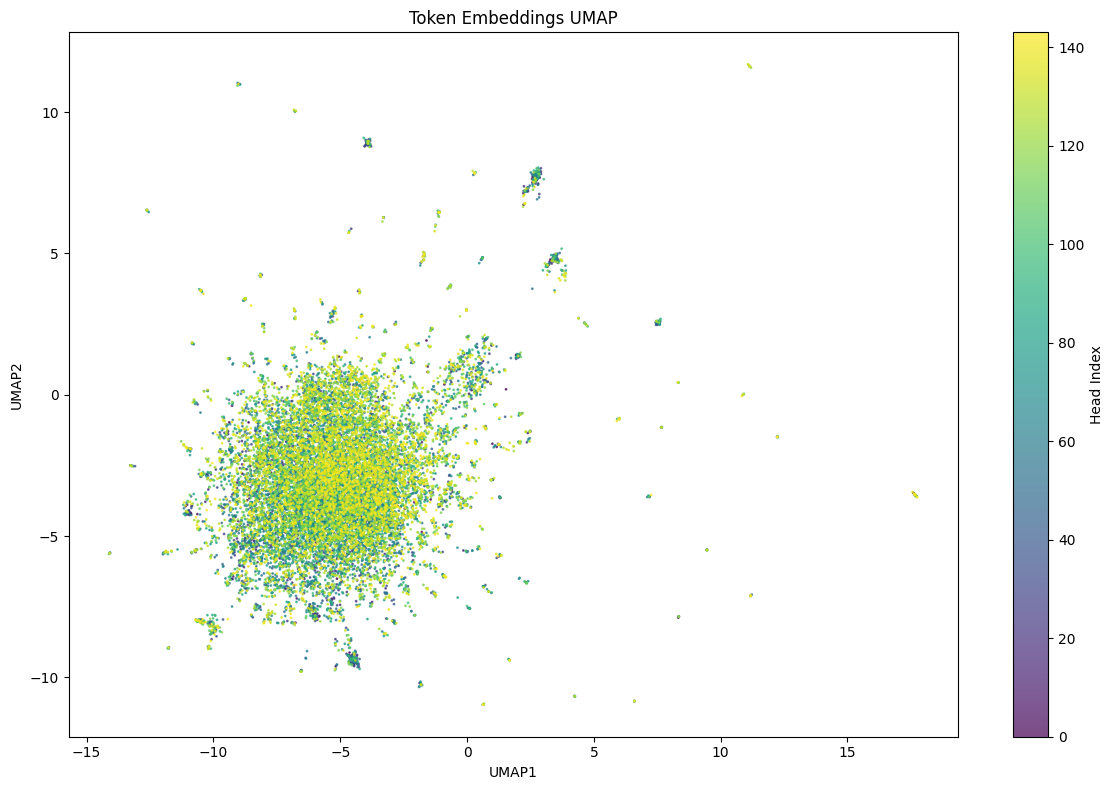

In [167]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import umap

def plot_token_embeddings_umap(token_counts, n_neighbors=15, min_dist=0.1, jitter_scale=0.1):
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colormap = cm.viridis
    
    # Get the unique tokens and their corresponding heads
    token_heads = token_counts[['Token', 'Head']].drop_duplicates()
    
    # Get the token embeddings
    token_embeddings = []
    for token in token_heads['Token']:
        embedding = cache.model.embed(token).detach().cpu().numpy()
        token_embeddings.append(embedding)
    
    # Perform UMAP on the token embeddings
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    token_embeddings_umap = umap_model.fit_transform(token_embeddings)
    
    # Create a DataFrame with the UMAP components and head indices
    df_umap = pd.DataFrame(token_embeddings_umap, columns=['UMAP1', 'UMAP2'])
    df_umap['Token'] = token_heads['Token']
    df_umap['Head'] = token_heads['Head']
    
    # Add jitter to the UMAP components
    jitter = np.random.normal(scale=jitter_scale, size=(df_umap.shape[0], 2))
    df_umap[['UMAP1', 'UMAP2']] += jitter
    
    # Plot the UMAP components with color representing the head index
    plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['Head'], cmap=colormap, s=1, alpha=0.7)
    
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('Token Embeddings UMAP')
    plt.colorbar(label='Head Index')
    
    plt.tight_layout()
    plt.show()

plot_token_embeddings_umap(token_counts, n_neighbors=25, min_dist=0.5, jitter_scale=0.001)

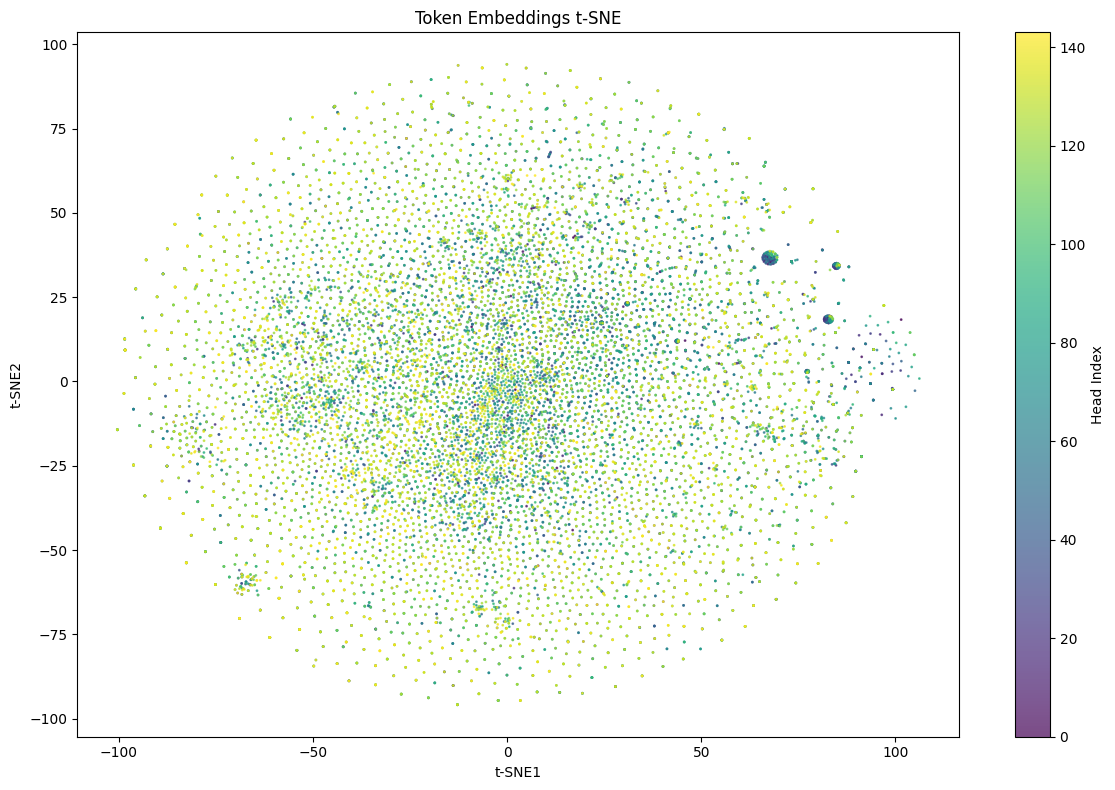

In [157]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE

def plot_token_embeddings_tsne(token_counts, perplexity=30, learning_rate=200, jitter_scale=0.1):
    plt.figure(figsize=(12, 8))

    # Create a colormap
    colormap = cm.viridis

    # Get the unique tokens and their corresponding heads
    token_heads = token_counts[['Token', 'Head']].drop_duplicates()

    # Get the token embeddings
    token_embeddings = []
    for token in token_heads['Token']:
        embedding = cache.model.embed(token).detach().cpu().numpy()
        token_embeddings.append(embedding)

    # Perform t-SNE on the token embeddings
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    token_embeddings_tsne = tsne.fit_transform(np.stack(token_embeddings))

    # Create a DataFrame with the t-SNE components and head indices
    df_tsne = pd.DataFrame(token_embeddings_tsne, columns=['t-SNE1', 't-SNE2'])
    df_tsne['Token'] = token_heads['Token']
    df_tsne['Head'] = token_heads['Head']

    # Plot the t-SNE components with color representing the head index
    plt.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=df_tsne['Head'], cmap=colormap, s=1, alpha=0.7)

    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.title('Token Embeddings t-SNE')
    plt.colorbar(label='Head Index')

    plt.tight_layout()
    plt.show()

plot_token_embeddings_tsne(token_counts, perplexity=30, learning_rate=200)

## Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 62 times.

In [ ]:
token = random.randint(0, 50257)
prompt = torch.full((1, 62), token)
cache = run_prompts(model, *model.to_string(prompt))
plots = plot_attns(cache, range(12), hide_labels=True)

plot_grid(*plots, title="Attention tokens", description=f'Input: "{cache.prompts[0][:99]}..."')

In [ ]:
prompt = torch.randint(0, 50257, (1, 62))
cache = run_prompts(model, *model.to_string(prompt))
plots = plot_attns(cache, range(12), hide_labels=True)

plot_grid(*plots, title="Attention tokens", description=f'Input: "{cache.prompts[0][:99]}..."')

In [ ]:
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 21)
cache = run_prompts(model, *model.to_string(prompt))
plots = plot_attns(cache, range(12), show_grid_labels=False, show_axis=False, show_attn_overlay=False)

plot_grid(*plots, title="Attention tokens", description=f'Input: "{cache.prompts[0][:128]}"')

### A note in input length

Input length is important. Up to 31 tokens the attention tokens form surprisingly compact representations of the input across each position. At 32 input tokens some kind of criticality is reached, which dramatically increases the number of attention tokens defined for each input token. You can see this below where the final two lines account for the majority of assigned tokens. It's important to note this doesn't change the existing patterns above, but just makes it much more difficult to view them clearly using this visualization technique.

After 32 tokens, things get a bit weird. The attention token structure doesn't remain in the more complex high token count state - instead it appears to alternate between the simple and complex patterns. However, this somewhat depends on the selected random token so it's difficult to highlight a precise sequence.

Below is the same head (0.0) plotted using input from 31 up to 48 tokens. You can see the simple and complex pattern evolve twice in this range.

In [ ]:
token = random.randint(0, 50257)
plots = []
for i in range(31, 47, 2):
    prompt = torch.full((1, i), token)
    cache = run_prompts(model, *model.to_string(prompt), prepend_bos=False)
    plots += plot_attns(cache, range(1), hide_labels=True, prepend_bos=False)

plot_grid(*plots, title="Random inputs between 31 and 48 tokens (0.0)", description=f'Input: "{cache.prompts[0][:99]}"')

The same behaviour occurs with natural language input, but the threshold is less predictable. The point of criticality appears to align with the start of the most recent "block" of text. E.g. if it's a repeating sequence of length 4 the threshold is ~28. This isn't precise, but is relisably closer than 32 as seen with repeated and fully random inputs.

In [ ]:
plots = []
tokens = model.to_tokens(random.choice(dataset["train"]["text"]))
for i in range(31, 47, 2):
    prompt = tokens[:, :i]
    cache = run_prompts(model, *model.to_string(prompt))
    plots += plot_attns(cache, range(1), hide_labels=True)

plot_grid(*plots)

## Specific head analysis

Random repeating sequences provides the clearest interpretability without being devoid of structure so I'm starting there. Understanding how heads evolve based on changing predictable sequences is likely to provide more general insights, but it's worth noting again the risk of these toy inputs not translating to more realistic language.

To provide some structure to the work I plan to evaluate the patterns using this approach:
- Take an input sequence (S) and convert it into a sequence of attention tokens (A)
- Given the next token (t) generate a new sequence of attention tokens using S + t
- Analyse the invariances and symmetries implied by how different sequences produce different attention tokens

### 0.0